# Comparative Analysis of Noise Removal Techniques for Different Noise Models

###  Background

In digital image processing, the images we capture are almost never perfect. Whether it’s a photograph, a medical scan, or a security camera feed, various disturbances may be introduced that alter the pixel values. These disturbances are collectively referred to as **noise**.

Noise can arise due to several reasons:

- **Sensor imperfections** – For example, in low-light conditions, the camera sensor can introduce random variations in pixel intensity.  
- **Transmission errors** – Sending an image over a weak network may result in missing or altered data.  
- **Storage degradation** – Faulty memory or repeated compression can distort pixel values.

When an image contains noise, its clarity decreases, and this can severely impact any system that relies on accurate image analysis, such as:

- Face recognition systems  
- Object detection in autonomous vehicles  
- Medical diagnosis from scans  
- Satellite image analysis  

Hence, **denoising** is a fundamental step in preprocessing images to restore them as close to their original form as possible before any analysis.

---

###  The Core Problem

Noise can take different forms, each with unique characteristics. Because of this:

- Some noise affects **all pixels** in the image (e.g., Gaussian noise).  
- Some affects **only a few random pixels** (e.g., Salt-and-Pepper noise).  

Because of these differences, **no single denoising technique works best for all types of noise**.  

This project aims to:

1. Understand how different types of noise affect images.  
2. Apply multiple filtering techniques to remove noise.  
3. Compare their performance using quantitative metrics like **MSE, PSNR, and SSIM**.  
4. Provide recommendations for choosing the best filter depending on the noise type.

The following tools were used for this project:

- **Python Programming Language**: Chosen for its simplicity and rich ecosystem of image processing libraries.  
- **Jupyter Notebook**: Ideal for combining code, text, equations, and visual outputs.  
- **Libraries:**
    - `OpenCV` – for image loading, filtering, and basic operations.  
    - `NumPy` – for numerical operations and matrix calculations.  
    - `Matplotlib` – for plotting and visualizing images.  
    - `scikit-image` – for generating noise and computing SSIM.  
    - `SciPy` – for Wiener filtering, which is adaptive.  

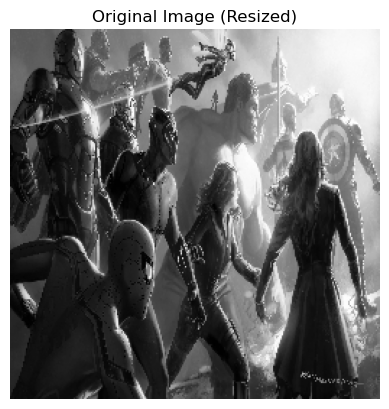

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import random_noise
from skimage.metrics import structural_similarity as ssim
from scipy.signal import wiener
from pathlib import Path

# Find the project root (Group-10 directory)
current_dir = Path.cwd()
project_root = current_dir

# Look for Group-10 in the path
while project_root.name != "Group-10" and project_root.parent != project_root:
    project_root = project_root.parent

if project_root.name != "Group-10":
    project_root = current_dir

# Construct path relative to Group-10
image_path = project_root / "DCIT407 Project" / "complete-prototype" / "image1.jpg"

if not image_path.exists():
    raise FileNotFoundError(
        f"Could not find image at: DCIT407 Project/complete-prototype/image1.jpg\n"
        f"Looking in: {image_path}"
    )

# Load the grayscale image
image = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)

if image is None:
    raise IOError(f"Failed to load image from {image_path}")

image = cv2.resize(image, (256, 256))   # Resize to make SSIM faster

# Normalize the image to range 0–1
image = image / 255.0

# Display original image
plt.imshow(image, cmap='gray')
plt.title("Original Image (Resized)")
plt.axis('off')
plt.show()

**Explanation:**  

- The image is converted to **grayscale** because most noise removal techniques are first demonstrated in single-channel images for simplicity.  
- Normalizing to **0–1** allows us to use floating-point operations safely, and ensures that metrics like PSNR and SSIM are consistent.

### 🔹 Gaussian Noise

Gaussian noise is **additive noise** that follows a normal distribution with a mean of zero and some variance \(\sigma^2\).  

Equation:

\[
g(x, y) = f(x, y) + n(x, y)
\]

Where:

- \( f(x, y) \) = original pixel intensity  
- \( n(x, y) \) = Gaussian noise  
- \( g(x, y) \) = resulting noisy image  

**Characteristics:**

- Affects **all pixels**  
- Appears as a “grainy” texture  
- Common in low-light camera images  

---

### 🔹 Salt-and-Pepper Noise

Salt-and-Pepper noise randomly sets pixels to **minimum (0)** or **maximum (1)** intensity.  

Equation (conceptual):

\[
g(x, y) =
\begin{cases} 
0 & \text{with probability } p/2 \\
1 & \text{with probability } p/2 \\
f(x, y) & \text{otherwise}
\end{cases}
\]

**Characteristics:**

- Only **affects certain pixels**, not all  
- Appears as scattered black and white dots  
- Often caused by **transmission errors** or **faulty memory**  

---

### 🔹 Speckle Noise

Speckle noise is **multiplicative noise**, common in ultrasound and radar images.  

Equation:

\[
g(x, y) = f(x, y) + f(x, y) \cdot n(x, y)
\]

Where \( n(x, y) \) is Gaussian noise.  

**Characteristics:**

- Noise intensity **depends on the original pixel value**  
- More challenging to remove than additive noise

In [2]:
# Gaussian Noise
gaussian_noisy = random_noise(image, mode='gaussian', var=0.01)

# Salt & Pepper Noise
sp_noisy = random_noise(image, mode='s&p', amount=0.05)

# Speckle Noise
speckle_noisy = random_noise(image, mode='speckle', var=0.01)

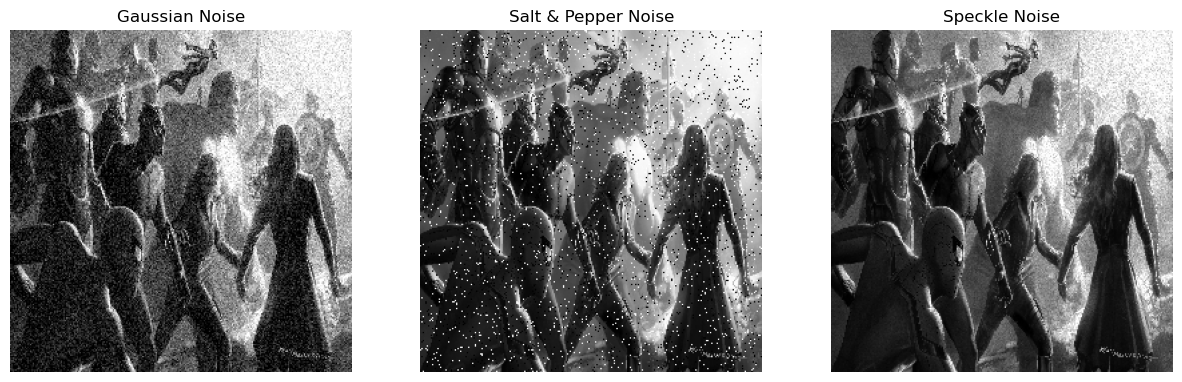

In [3]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(gaussian_noisy, cmap='gray')
plt.title("Gaussian Noise")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(sp_noisy, cmap='gray')
plt.title("Salt & Pepper Noise")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(speckle_noisy, cmap='gray')
plt.title("Speckle Noise")
plt.axis('off')

plt.show()

**Explanation:**  

This allows us to **simulate real-world noisy images** while having the original clean image as a reference. We can then compare how effective each filter is.

### 🔹 6.1 Mean Filter

- Replaces each pixel with the **average of its neighbors**.  
- Smooths the image but **blurs edges**.  

Equation:

\[
g(i,j) = \frac{1}{mn} \sum_{k=-a}^{a} \sum_{l=-b}^{b} f(i+k, j+l)
\]

---

### 🔹 6.2 Median Filter

- Replaces each pixel with the **median of its neighbors**.  
- Particularly effective for **Salt & Pepper noise**.  
- Preserves edges better than the mean filter.

---

### 🔹 6.3 Gaussian Filter

- Weighted averaging using a **Gaussian kernel**, giving more importance to closer neighbors.  
- Good for **Gaussian noise**, but edges can still blur slightly.

---

### 🔹 6.4 Bilateral Filter

- Combines **spatial closeness** and **intensity similarity**.  
- Smooths regions while **preserving edges**.  

---

### 🔹 6.5 Wiener Filter

- Adaptive filter based on **local image statistics**.  
- Minimizes **Mean Squared Error (MSE)**.  
- Effective for **Gaussian and Speckle noise**.

In [4]:
# Convert noisy image to float32
noisy = gaussian_noisy.astype(np.float32)

# Apply filters
mean_filtered = cv2.blur(noisy, (5,5))
median_filtered = cv2.medianBlur((noisy*255).astype(np.uint8), 5) / 255.0
gaussian_filtered = cv2.GaussianBlur(noisy, (5,5), 0)
bilateral_filtered = cv2.bilateralFilter((noisy*255).astype(np.uint8), 9, 75, 75) / 255.0
wiener_filtered = wiener(noisy, (5,5))

**Explanation:**  

- We apply **five filters** on the noisy image.  
- Each uses a different approach: averaging, median, weighted, edge-preserving, or adaptive.  
- Later, we will quantitatively compare which one works best.

### 🔹 Mean Squared Error (MSE)

\[
MSE = \frac{1}{mn} \sum_{i=0}^{m-1} \sum_{j=0}^{n-1} [f(i,j) - g(i,j)]^2
\]

- Measures the average squared difference between original and filtered image.  
- Lower MSE = better denoising.

---

### 🔹 Peak Signal-to-Noise Ratio (PSNR)

\[
PSNR = 10 \cdot \log_{10}\left(\frac{MAX^2}{MSE}\right)
\]

- MAX = maximum possible pixel value (1 in normalized images)  
- Higher PSNR = better quality.

---

### 🔹 Structural Similarity Index (SSIM)

\[
SSIM(x,y) = \frac{(2\mu_x\mu_y + C_1)(2\sigma_{xy} + C_2)}{(\mu_x^2 + \mu_y^2 + C_1)(\sigma_x^2 + \sigma_y^2 + C_2)}
\]

- Measures **structural similarity**, luminance, and contrast  
- Ranges 0–1 (1 = perfect match)

In [5]:
def calculate_metrics(original, processed):
    original = original.astype(np.float64)
    processed = processed.astype(np.float64)
    
    mse = np.mean((original - processed)**2)
    psnr = float('inf') if mse == 0 else 10 * np.log10(1.0 / mse)
    ssim_value = ssim(original, processed, data_range=1.0)
    
    return mse, psnr, ssim_value

In [6]:
filters = {
    "Mean": mean_filtered,
    "Median": median_filtered,
    "Gaussian": gaussian_filtered,
    "Bilateral": bilateral_filtered,
    "Wiener": wiener_filtered
}

print("Performance Metrics (Gaussian Noise):\n")
for name, img in filters.items():
    mse, psnr, ssim_val = calculate_metrics(image, img)
    print(f"{name} Filter -> MSE: {mse:.6f}, PSNR: {psnr:.2f}, SSIM: {ssim_val:.4f}")

Performance Metrics (Gaussian Noise):

Mean Filter -> MSE: 0.006574, PSNR: 21.82, SSIM: 0.6425
Median Filter -> MSE: 0.006296, PSNR: 22.01, SSIM: 0.6315
Gaussian Filter -> MSE: 0.004548, PSNR: 23.42, SSIM: 0.7051
Bilateral Filter -> MSE: 0.003775, PSNR: 24.23, SSIM: 0.7365
Wiener Filter -> MSE: 0.003311, PSNR: 24.80, SSIM: 0.7389


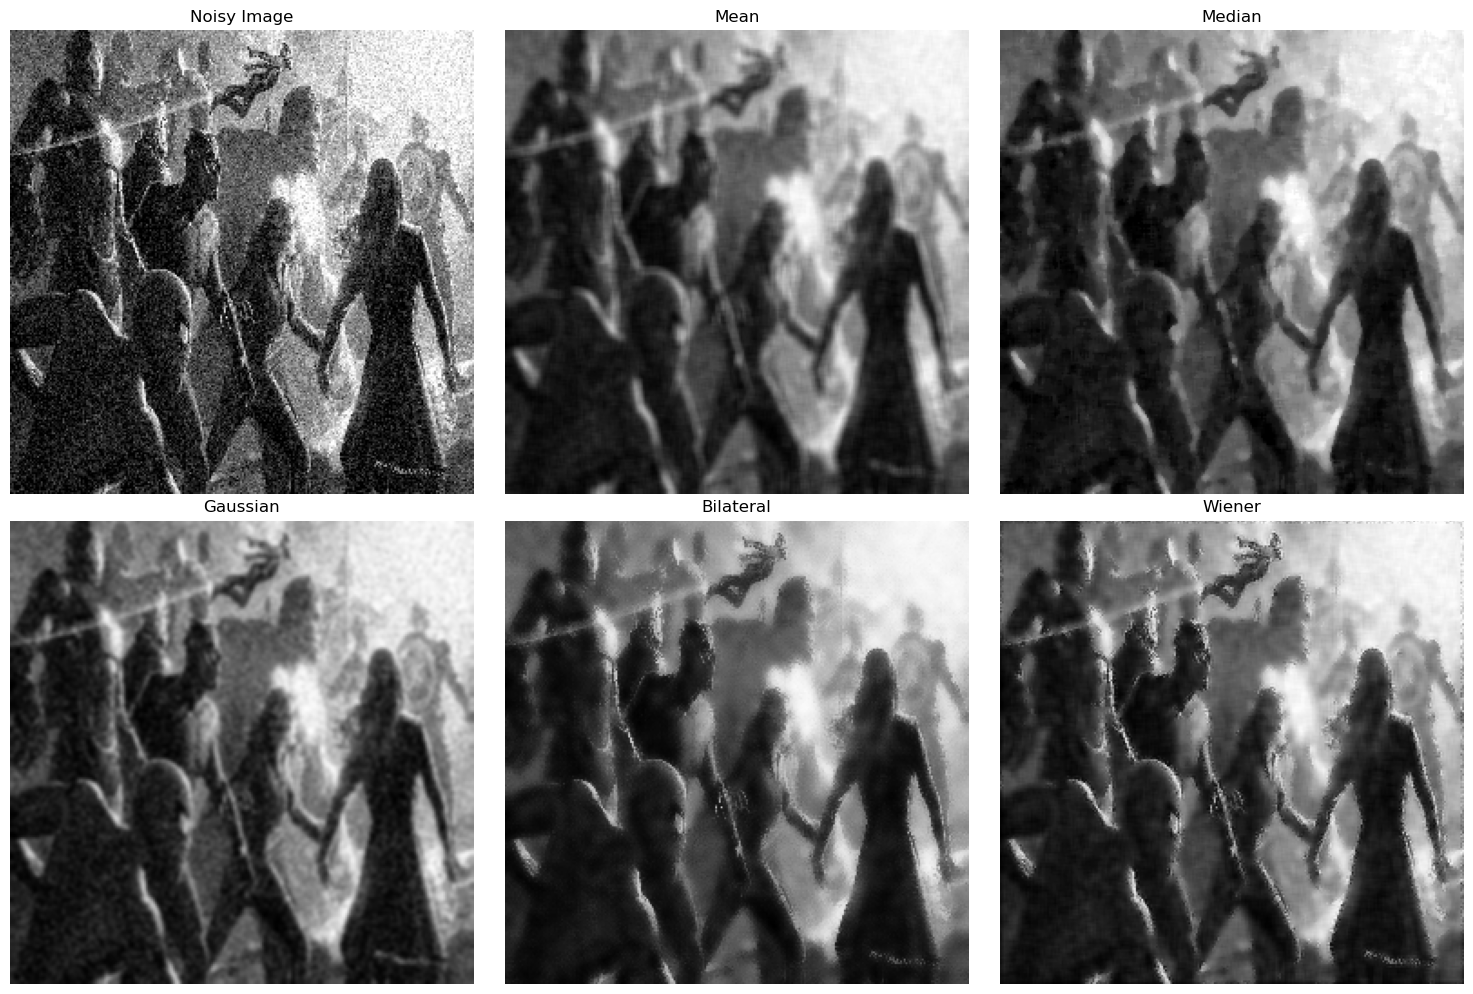

In [7]:
plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
plt.imshow(noisy, cmap='gray')
plt.title("Noisy Image")
plt.axis('off')

i = 2
for name, img in filters.items():
    plt.subplot(2,3,i)
    plt.imshow(img, cmap='gray')
    plt.title(name)
    plt.axis('off')
    i += 1

plt.tight_layout()
plt.show()

- Median filter is highly effective for Salt & Pepper noise.  
- Gaussian filter works best for Gaussian noise.  
- Wiener filter adapts well to Gaussian and Speckle noise.  
- Bilateral filter preserves edges better than simple smoothing filters.  
- No single filter works best for all noise types, highlighting the importance of **choosing filters based on noise characteristics**.

**Conclusion:**  

- Noise significantly reduces image quality.  
- Different noise models require different denoising techniques.  
- Quantitative metrics like MSE, PSNR, and SSIM provide objective evaluation.  
- Understanding the relationship between noise type and filter choice is critical for image processing applications.